## [ 식재료 이미지 인식할 때 훈련하는 코드]

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
##train에서 파일명 리스트
path = r'C:\Users\user'
trainFileList = os.listdir(path+'\\reimages\\')
len(trainFileList)

5

In [3]:
##랜덤 3200개 뽑기
import random
moveList = random.sample(trainFileList,432)
len(moveList)

ValueError: Sample larger than population or is negative

In [ ]:
#3200개 옮기기
import shutil
currentPath = path+'\\reimages'
targetPath = path+'\\test'
for file in moveList:
    try:
        shutil.move(currentPath+'\\'+file, targetPath+'\\'+file)
    except:
        pass


#### [여기서부터 시작]

In [2]:
path = r'C:\\AIP\\python_workspace\\venv\\ML\\FinalProject_classify2\\'
trainPath = 'C:\\AIP\\python_workspace\\venv\\ML\\FinalProject_classify2\\reimages\\'
testPath = 'C:\\AIP\\python_workspace\\venv\\ML\\FinalProject_classify2\\test\\'
currentPath = path+'\\reimages'
targetPath = path+'\\test'
trainFileList = os.listdir(trainPath)
testFileList = os.listdir(testPath)
trainFileList = os.listdir(path+'\\reimages\\')
print(trainFileList)

['carrot', 'egg', 'onion', 'radish', 'rpepper']


In [ ]:
'''
실행 안해도 됨 
'''
plant_label = {'carrot':0,'egg':1, 'onion':2,'radish':3, 'rpepper':4}
trainPath = 'C:\\AIP\\python_workspace\\venv\\ML\\FinalProject_classify2\\reimages\\'
testPath = 'C:\\AIP\\python_workspace\\venv\\ML\\FinalProject_classify2\\test\\'

In [ ]:
'''
실행 안해도 됨 
'''

ingredient_label = {'carrot':0,'egg':1, 'onion':2,'radish':3, 'rpepper':4}
try:
    for key in ingredient_label.keys():
        os.makedirs(trainPath+key)
except:
    pass


In [ ]:
'''
실행 안해도 됨 
'''
ingredient_label = {'carrot':0,'egg':1, 'onion':2,'radish':3, 'rpepper':4}
try:
    for key in ingredient_label.keys():
        os.makedirs(testPath+key)
except:
    pass

In [ ]:
'''
실행 안해도 됨 
'''

trainPath = 'C:\\AIP\\python_workspace\\venv\\ML\\FinalProject_classify2\\reimages\\'
testPath = 'C:\\AIP\\python_workspace\\venv\\ML\\FinalProject_classify2\\test\\'
for file in trainFileList:
    label = file.split(' ')[0]+'_'+file.split(' ')[1]
    targetPath = trainPath + label+'\\'
    try:
        shutil.move(trainPath+file,targetPath+file)
    except:
        pass


In [ ]:
'''
실행 안해도 됨 
'''

for file in testFileList:
    label = file.split(' ')[0]+'_'+file.split(' ')[1]
    targetPath = testPath + label+'\\'
    try:
        shutil.move(testPath+file,targetPath+file)
    except:
        pass

In [ ]:
###############################################################################################################

In [3]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                 rotation_range = 30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=False,
                                 vertical_flip=False,
                                 fill_mode='nearest'
                                 )

In [4]:
trainGenSet = trainDataGen.flow_from_directory(
    path + '\\reimages',
    batch_size=16,
    target_size=(128, 128),
    class_mode='categorical',
)

Found 1728 images belonging to 5 classes.


In [5]:
testDataGen = ImageDataGenerator(rescale=1./255) # evaluate_generator(testGenSet, steps=16) 할 때 쓰임 

In [6]:
testGenSet = testDataGen.flow_from_directory(
    path + '\\test',
    target_size=(128,128),
    batch_size=16,
    class_mode='categorical'
)

Found 432 images belonging to 5 classes.


#### =======================model selection 부분==========================

## [model : inception]

In [12]:
print('https://medium.com/coinmonks/paper-review-of-googlenet-inception-v1-winner-of-ilsvlc-2014-image-classification-c2b3565a64e7')

https://medium.com/coinmonks/paper-review-of-googlenet-inception-v1-winner-of-ilsvlc-2014-image-classification-c2b3565a64e7


In [15]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3),classes=5)
# base_model.summary()
# 글로벌 공간 평균값 풀링 레이어를 더합니다
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 완전 연결 레이어를 더합니다
x = Dense(256, activation='relu')(x)
# 로지스틱 레이어를 더합니다 -- 200가지 클래스가 있다고 가정합니다
predictions = Dense(5, activation='softmax')(x)

# 다음은 학습할 모델입니다
model = Model(inputs=base_model.input, outputs=predictions)
model.summary() # InceptionV3 모델에 내 모델 이어 붙이기 ( include = False 했기 떄문에 붙여지는 거임 )

############################     이거 중요한 코드임..##########################################
# 첫째로: (난수로 초기값이 설정된) 가장 상위 레이어들만 (즉, 내가 적은 GlobalAveragePooling2D()(x) ) 학습시킵니다
# 다시 말해서 모든 InceptionV3 콘볼루션 레이어를 고정합니다 
for layer in base_model.layers:
    layer.trainable = False

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 63, 63, 32)   96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization_8[0][0]      
_______________________________________________________________________________________

## [model : resnet]

In [ ]:
print('참고 사이트 ')
print('https://rarena.tistory.com/entry/keras-%ED%8A%B9%EC%A0%95-%EB%AA%A8%EB%8D%B8%EB%A1%9C%EB%93%9C%ED%95%98%EC%97%AC-%EB%82%B4-%EB%A0%88%EC%9D%B4%EC%96%B4')

In [7]:
from keras.applications import ResNet50

input = Input(shape=(128, 128, 3))

base_model = ResNet50(input_tensor=input, include_top=False, weights='imagenet', pooling='max') # include_top = False ==> dense(1000)안한다.
# base_model.summary()

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = Dense(1024, name='fully', kernel_initializer='random_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(512, kernel_initializer='random_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(5, activation='softmax', name='softmax')(x)

model = Model(base_model.input, predictions)
model.summary()  # resnet50 모델에 내 모델 이어 붙이기 ( include = False 했기 떄문에 붙여지는 거임 )


##### FINE TUNING Weght 동결 부분#### 
############################    이거 중요한 코드임..##########################################
# 첫째로: (난수로 초기값이 설정된) 가장 상위 레이어들만 (즉, 내가 적은 Dense(1024 .. ) 라인부터) 학습시킵니다
# 다시 말해서 모든 InceptionV3 콘볼루션 레이어를 고정합니다 
for layer in base_model.layers:
    layer.trainable = False

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## [model : our CNN]

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model=Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(128,128,3),activation='relu'))
model.add(MaxPool2D((2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D((2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D((2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D((2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=1024,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D((2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_112 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 32, 32, 256)      

## [model : vgg16]

In [21]:
from keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3),classes=5)
# base_model.summary()
# 글로벌 공간 평균값 풀링 레이어를 더합니다
x = base_model.output
x = Flatten()(x)
x = Dense(4096, name='fully', kernel_initializer='random_uniform')(x)
x = Activation('relu')(x)
x = Dense(4096, kernel_initializer='random_uniform')(x)
x = Activation('relu')(x)
predictions = Dense(5, activation='softmax', name='softmax')(x)

# 다음은 학습할 모델입니다
model = Model(inputs=base_model.input, outputs=predictions)
model.summary() # InceptionV3 모델에 내 모델 이어 붙이기 ( include = False 했기 떄문에 붙여지는 거임 )

############################     이거 중요한 코드임..##########################################
# 첫째로: (난수로 초기값이 설정된) 가장 상위 레이어들만 (즉, 내가 적은 GlobalAveragePooling2D()(x) ) 학습시킵니다
# 다시 말해서 모든 InceptionV3 콘볼루션 레이어를 고정합니다 
for layer in base_model.layers:
    layer.trainable = False
    

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

## =========================  모델 컴파일  ================================

In [8]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## =========================  학습하는 코드  ================================

#### (1) [fine_tuning 하기 전에 , 학습하는 코드]

In [9]:
'''
여기실행 할 차례 
'''
import timeit
start_time = timeit.default_timer() # 시작 시간 체크

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)


# early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
history = model.fit_generator(
    trainGenSet,
    steps_per_epoch=108,
    epochs=50,
    validation_data=testGenSet,
    validation_steps=27,
    callbacks=[earlystop]
)

terminate_time = timeit.default_timer() # 종료 시간 체크 
print("%f초 걸렸습니다." % (terminate_time - start_time))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
108/108 [==============================] - 64s 592ms/step - loss: 1.0626 - accuracy: 0.6372 - val_loss: 1.1694 - val_accuracy: 0.5718
Epoch 2/50
108/108 [==============================] - 60s 553ms/step - loss: 0.8125 - accuracy: 0.7054 - val_loss: 1.3839 - val_accuracy: 0.4931
Epoch 3/50
108/108 [==============================] - 53s 488ms/step - loss: 0.7635 - accuracy: 0.7141 - val_loss: 0.8095 - val_accuracy: 0.6806
Epoch 4/50
108/108 [==============================] - 53s 493ms/step - loss: 0.6804 - accuracy: 0.7459 - val_loss: 1.2054 - val_accuracy: 0.6204
Epoch 5/50
108/108 [==============================] - 55s 505ms/step - loss: 0.6544 - accuracy: 0.7483 - val_loss: 0.9639 - val_accuracy: 0.6597
Epoch 6/50
108/108 [==============================] - 53s 491ms/step - loss: 0.6220 - accuracy: 0.7685 - val_loss: 1.3004 - val_accuracy: 0.6250
Epoch 7/50
108/108 [==============================] - 

#### (2) [fine_tuning 한 후, 학습하는 코드]

In [12]:
'''
여기실행 할 차례 
'''
import timeit
start_time = timeit.default_timer() # 시작 시간 체크

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

checkpoint = ModelCheckpoint('model-resnet-{epoch:02d}.hdf5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
history = model.fit_generator(
    trainGenSet,
    steps_per_epoch=108,
    epochs=50,
    validation_data=testGenSet,
    validation_steps=27,
    callbacks=[earlystop,checkpoint]
)

terminate_time = timeit.default_timer() # 종료 시간 체크 
print("%f초 걸렸습니다." % (terminate_time - start_time))

Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 0.8937 - accuracy: 0.6620
Epoch 00001: val_loss improved from inf to 3.10984, saving model to model-resnet-01.hdf5
108/108 [==============================] - 67s 620ms/step - loss: 0.8937 - accuracy: 0.6620 - val_loss: 3.1098 - val_accuracy: 0.2477
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7338
Epoch 00002: val_loss did not improve from 3.10984
108/108 [==============================] - 58s 538ms/step - loss: 0.7106 - accuracy: 0.7338 - val_loss: 3.8903 - val_accuracy: 0.2523
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.7703
Epoch 00003: val_loss improved from 3.10984 to 2.22164, saving model to model-resnet-03.hdf5
108/108 [==============================] - 59s 549ms/step - loss: 0.6226 - accuracy: 0.7703 - val_loss: 2.2216 - val_accuracy: 0.3264
Epoch 4/50
108/108 [==============================] - ETA: 0s - loss: 0.6156 

- steps_per_epoch : 한 epoch에 사용한 스텝 수를 지정합니다. 총 1728개의 훈련 샘플이 있고 배치사이즈가 16이므로 108 스텝으로 지정합니다.
- epochs : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정합니다. 50번을 반복적으로 학습시켜 보겠습니다.
- validation_data : 검증데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 validation_generator으로 지정합니다.
- validation_steps : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정합니다. 홍 432개의 검증 샘플이 있고 배치사이즈가 16이므로 27 스텝으로 지정합니다.

[중요]
- patience 파라미터 값을 너무 작게 설정하면 딥러닝 모델이 더 개선될 여지가 있음에도 너무 일찍학습이 종료되어버릴 수 있다. 
- 그렇다고 patience 값을 너무 크게 해버리면 과적합이 이미 어느정도 진행된 상태에서 학습이 중단되어 버리는데, 
- 모델을 학습시키는 동안 에포크 마다 모델을 자동으로 저장해주는 ModelCheckpoiint 콜백 함수를 같이 사용하면 이 문제도 해결 할 수 있다.

## [ FINE TUNING]  : 먼저 내가 붙인 레이어 fit_generator 한다음, fine_tuning으로 N 상위레이어 학습

In [10]:
print('https://jeinalog.tistory.com/13')

https://jeinalog.tistory.com/13


In [11]:
# 이 시점에서 상위 레이어들은 충분히 학습이 되었기에,
# inception V3의 콘볼루션 레이어에 대한 파인튜닝을 시작합니다 
# 가장 밑 N개의 레이어를 고정하고 나머지 상위 레이어를 학습시킵니다

# 레이어 이름과 레이어 인덱스를 시각화하여
# 얼마나 많은 레이어를 고정시켜야 하는지 확인합니다:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# 가장 상위 2개의 inception 블록을 학습하기로 고릅니다,
# 다시 말하면 첫 249개의 레이어는 고정시키고 나머지는 고정하지 않습니다:
for layer in base_model.layers[:169]:
    layer.trainable = False
for layer in base_model.layers[169:]: # 상위 4% 만 학습 
    layer.trainable = True

# 이러한 수정사항이 효과를 내려면 모델을 다시 컴파일해야 합니다
# 낮은 학습 속도로 세팅된 SGD를 사용합니다
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# 다시 한 번 모델을 학습시킵니다
# (이번엔 상위 2개의 inception 블록을 상위의 밀집 레이어들과 함께 파인튜닝합니다)
# model.fit_generator(...)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
# model.save('InceptionV3_test1.h5')

## [ acc, loss 그래프 그리기 ]

In [ ]:
print('과대적합인지 보는 사이트 ')
print('https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko')

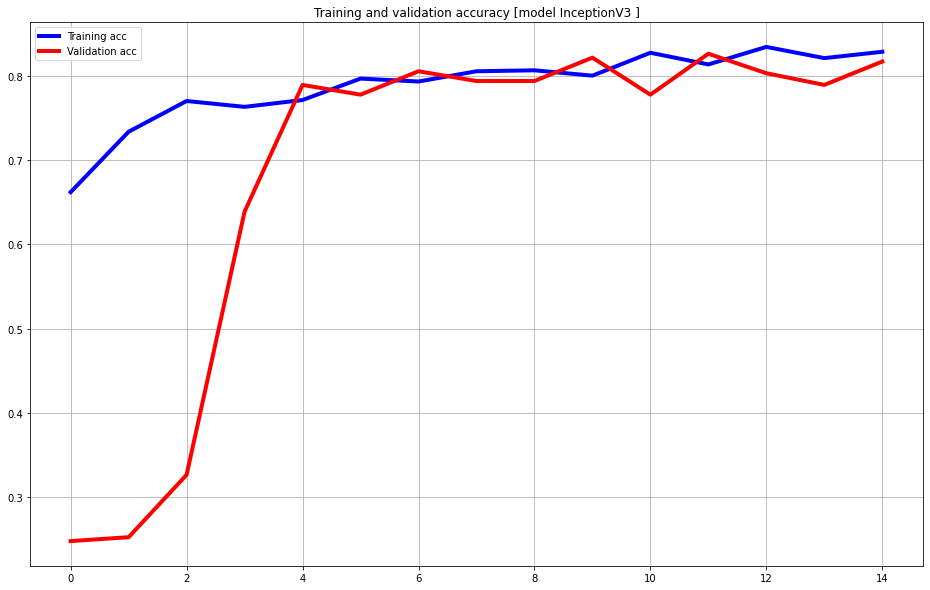

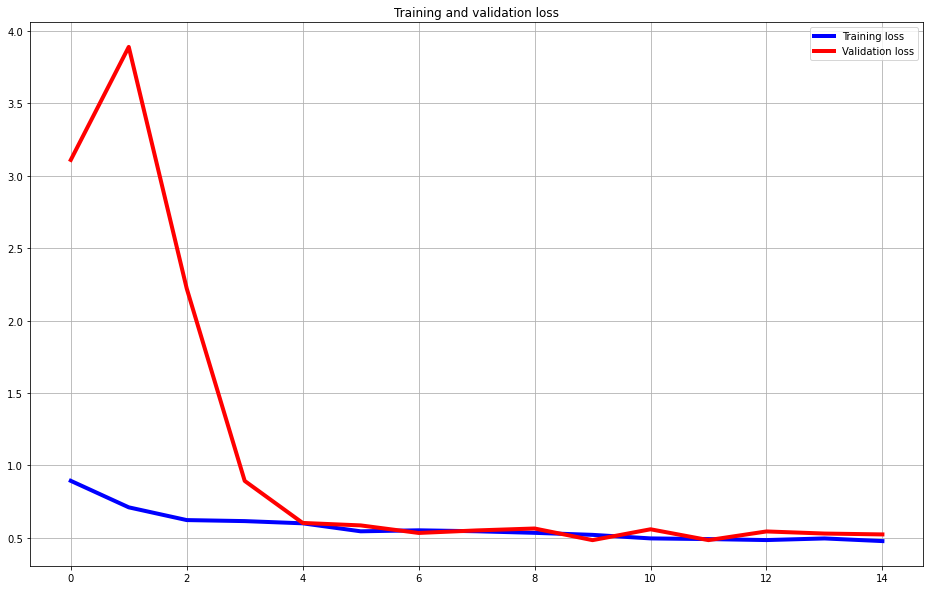

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy [model InceptionV3 ]')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()
# plt.imsave('inceptionV3_non_smooth_acc.jpg')

## Smooth Curve

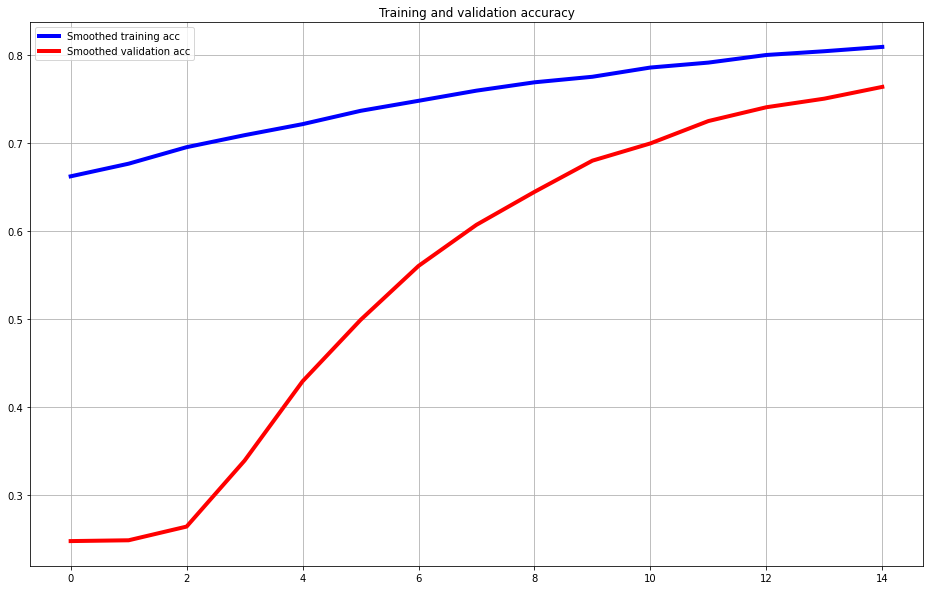

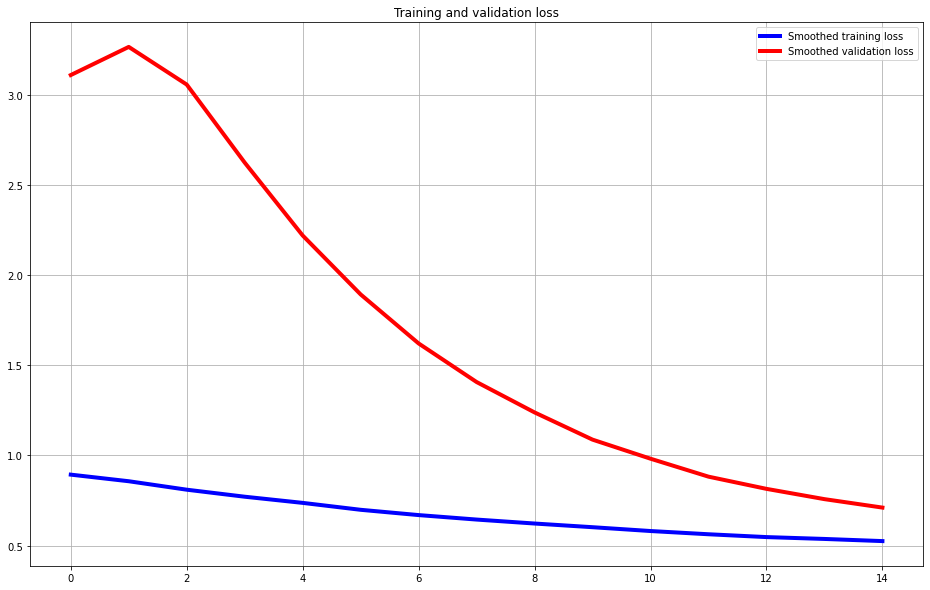

In [14]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'b', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'b', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ======================  모델 평가 하는 부분   ================================

In [15]:
print("-- evaluate --")
test_loss, test_acc = model.evaluate_generator(testGenSet, steps=16)
# test_loss = model.evaluate_generator(testGenSet, steps=16)

print('test loss:', test_loss)
print('test acc:', test_acc)

-- evaluate --
Instructions for updating:
Please use Model.evaluate, which supports generators.
test loss: 0.5226293206214905
test acc: 0.80859375


In [ ]:
print("-- Predict --")
output = model.predict_generator(
            testGenSet, 
            steps = 16)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# print(output, testGenSet.filenames)
for i in range(20):
    print(output[i], testGenSet.filenames[i])

In [ ]:
print(trainGenSet.class_indices)

## ===============[ 단위 테스트 ]==============

In [ ]:
# 2. 모델 불러오기
from keras.models import load_model
inception_model = load_model('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\model-inception-41.hdf5')
print('모델 불러오기 성공 ~!')

In [ ]:
from PIL import Image
test_img_carrot = Image.open('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\ccc.jpg')
# test_img_carrot.show()
pix = np.array(test_img_carrot)
plt.imshow(pix)

In [ ]:
# 불러온 모델을 사용하여 임의의 이미지 test 하자
test_img_carrot = cv2.imread('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\ccc.jpg')
print(test_img_carrot.shape)

In [ ]:
############################# test 할 때 스케일링 동일하게 #######################################
test_img_carrot = test_img_carrot / 255.0
test_img_carrot = test_img_carrot[np.newaxis, :]
predict = inception_model.predict(test_img_carrot)

In [ ]:

my_dict = {'carrot': 0, 'egg': 1, 'onion': 2, 'radish': 3, 'rpepper': 4}

new_dict = {}
for k, v in my_dict.items():
    new_dict[v] = k

print('이 사진은 : ', new_dict[np.argmax(predict)])

## =============[본격적으로 test]================

In [ ]:
from PIL import Image
test_img_rpepper = Image.open('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\real3.JPG')
# test_img_rpepper.show()
pix = np.array(test_img_rpepper)
plt.imshow(pix)

In [ ]:
# 불러온 모델을 사용하여 임의의 이미지 test 하자
test_img_rpepper = cv2.imread('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\real3.JPG')
test_img_rpepper = cv2.cvtColor(test_img_rpepper, cv2.COLOR_BGR2RGB)

print(test_img_rpepper.shape)

In [ ]:
test_img_rpepper = cv2.resize(test_img_rpepper, dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
test_img_rpepper = test_img_rpepper / 255.0
print(test_img_rpepper.shape)

In [ ]:
# model 사용 test
from keras.models import load_model
inception_model = load_model('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\inception_model2_p5\\model-inception-33.hdf5')
print('모델 불러오기 성공 ~!')

In [ ]:
test_img_rpepper = test_img_rpepper[np.newaxis, :]
predict = inception_model.predict(test_img_rpepper)
print(predict[0])

# num_dict={0:0,1:0,2:0,3:0,4:0}
# test_img_rpepper = test_img_rpepper[np.newaxis, :]
# prob = inception_model.predict(test_img_rpepper)
# prob = prob[0]
# sortedprob = np.argsort(prob)[::-1]
# num_dict[sortedprob[0]]+=1
# num_dict

In [ ]:
my_dict = {'carrot': 0, 'egg': 1, 'onion': 2, 'radish': 3, 'rpepper': 4}

new_dict = {}
for k, v in my_dict.items():
    new_dict[v] = k

print('이 사진은 : ', new_dict[np.argmax(predict)])

## [feature map 시각화] 

In [41]:
from matplotlib import pyplot
from keras.models import load_model
# load the model
model = load_model('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\inception_model2_p5\\model-inception-33.hdf5')

# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)



1 conv2d (None, 63, 63, 32)
4 conv2d_1 (None, 61, 61, 32)
7 conv2d_2 (None, 61, 61, 64)
11 conv2d_3 (None, 30, 30, 80)
14 conv2d_4 (None, 28, 28, 192)
18 conv2d_8 (None, 13, 13, 64)
21 conv2d_6 (None, 13, 13, 48)
22 conv2d_9 (None, 13, 13, 96)
28 conv2d_5 (None, 13, 13, 64)
29 conv2d_7 (None, 13, 13, 64)
30 conv2d_10 (None, 13, 13, 96)
31 conv2d_11 (None, 13, 13, 32)
41 conv2d_15 (None, 13, 13, 64)
44 conv2d_13 (None, 13, 13, 48)
45 conv2d_16 (None, 13, 13, 96)
51 conv2d_12 (None, 13, 13, 64)
52 conv2d_14 (None, 13, 13, 64)
53 conv2d_17 (None, 13, 13, 96)
54 conv2d_18 (None, 13, 13, 64)
64 conv2d_22 (None, 13, 13, 64)
67 conv2d_20 (None, 13, 13, 48)
68 conv2d_23 (None, 13, 13, 96)
74 conv2d_19 (None, 13, 13, 64)
75 conv2d_21 (None, 13, 13, 64)
76 conv2d_24 (None, 13, 13, 96)
77 conv2d_25 (None, 13, 13, 64)
87 conv2d_27 (None, 13, 13, 64)
90 conv2d_28 (None, 13, 13, 96)
93 conv2d_26 (None, 6, 6, 384)
94 conv2d_29 (None, 6, 6, 96)
101 conv2d_34 (None, 6, 6, 128)
104 conv2d_35 (None, 6, 6

#### [ (1) 첫번쨰 convolution layer 통과 한 후 feature map 시각화 해보기]

In [42]:
# redefine model to output right after the first hidden layer (첫번쨰 convolution layer 통과시 )
model = Model(inputs=model.inputs, outputs=model.layers[200].output) # 지금은 52번 conv layer 통과시 feature map 추출 

In [43]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# load the image with the required shape
img = load_img('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\yyy1.JPG', target_size=(128, 128))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)

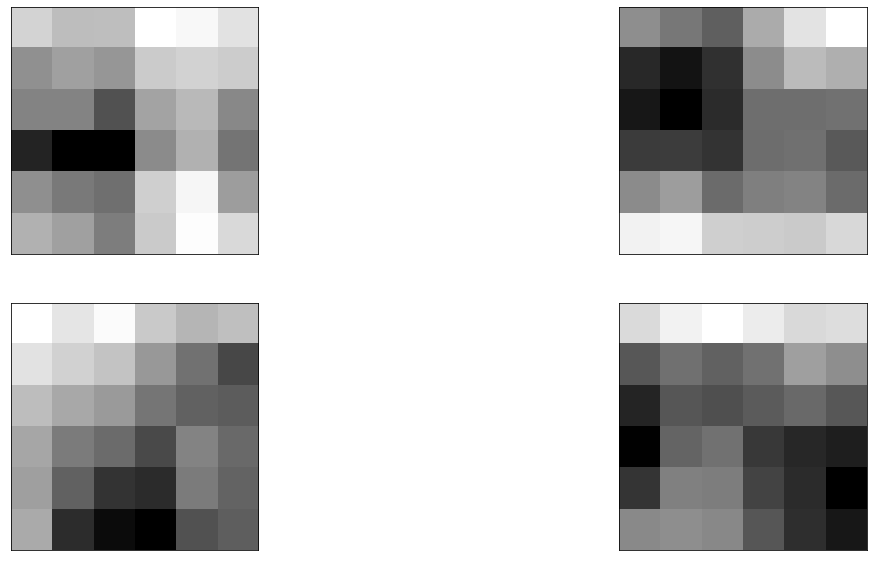

In [44]:
import matplotlib.pyplot as plt
# plot all 64 maps in an 8x8 squares
plt.figure(figsize=(20,10))
square = 2
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


- 모델의 입력에 더 가까운 기능 맵이 이미지의 많은 세부 사항을 캡처하고 모델에 더 깊이 들어가면 기능 맵이 점점 더 적은 세부 정보를 표시 함을 알 수 있습니다.

## [webcam 연결]

In [4]:
from keras.models import load_model
inception_model = load_model('C:\\AIP\python_workspace\\venv\\ML\\FinalProject_classify2\\inception_model2_p5\\model-inception-41.hdf5')
print('inceptionV3 모델 연결 완료')

inceptionV3 모델 연결 완료


In [5]:
my_dict = {'carrot': 0, 'egg': 1, 'onion': 2, 'radish': 3, 'rpepper': 4}

new_dict = {}
for k, v in my_dict.items():
    new_dict[v] = k
print('-------환경세팅완료-----')

-------환경세팅완료-----


In [6]:
import cv2
import numpy as np
from PIL import Image , ImageFont, ImageDraw
from keras import models
import math

#Load the saved model
video = cv2.VideoCapture(0)

while True:
        _, frame = video.read()
        #Capture Frame을 RGB로 변환 
        image = Image.fromarray(frame, 'RGB')
        image = np.array(image)   # (480, 640, 3)   center 
        (height, width) = image.shape[:2]  # height = 480 , width = 640 
        
        image_slicing = image[120:360, 160:480] # image slicing (이미지 부분 추출)
        
        
         ################################### 파란색 직사각형그리기 ####################################################### 
#         cv2.rectangle(frame,(160,120,width//2,height//2),(255,0,0),4)  # 파란색으로 직사각형 그리는 부분 
    
    
        ############################### [ Frame 에서 객체 추출 및 객체 bounding box 작업 ] ##############################
# ----------------------------------------------------------------------------------------------------------------------------
        dst = cv2.cvtColor(image_slicing, cv2.COLOR_BGR2GRAY)
        _,th = cv2.threshold(dst, 0,255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
        dst = cv2.cvtColor(th, cv2.COLOR_GRAY2BGR)

        _,labels, stats, centroids = cv2.connectedComponentsWithStats(th)
        # print(stats)

        count = 0
        obj_list = []
        for x,y,w,h,cnt in stats: 
            frame_obj_x = x+160
            frame_obj_y = y+120
            frame_obj_center_x = frame_obj_x + (h//2)
            frame_obj_center_y = frame_obj_y + (w//2)
            distance_between_obj_frame_center =  math.sqrt( ((frame_obj_center_x-240)**2)+((frame_obj_center_y-320)**2) )
            if  (h,w) < (240,320) and w<320 and h <240 and cnt>1000 and distance_between_obj_frame_center<100.0 :
                kk = []
                kk.append(frame_obj_x)
                kk.append(frame_obj_y)
                kk.append(w)
                kk.append(h)
                obj_list.append(kk)
#                 cv2.rectangle(frame,(frame_obj_x,frame_obj_y,w,h),(0,0,255),2) ## 객체인 부분만 직사각형 그림 
                count +=1

#-------------------------------------------------------------------------------------------------------------------------------
        ########################################## [ Predict ] ############################################################

        if len(obj_list) == 1:   
            px,py,pw,ph = obj_list[0]
#             image_slicing2 = image[px:px+ph, py:py+pw] # image slicing (이미지 부분 추출)
#             image_slicing2 = cv2.resize(image_slicing2, dsize=(128, 128), interpolation=cv2.INTER_LINEAR) #         훈련한 이미지가 128x128이기 때문에 frame을 input shape과 동일하게 설정
#             image_slicing2 = image_slicing2 / 255.0
#             image_slicing2 = image_slicing2[np.newaxis, :]
            image_slicing = cv2.resize(image_slicing, dsize=(128, 128), interpolation=cv2.INTER_LINEAR) 
            image_slicing = image_slicing / 255.0
            image_slicing = image_slicing[np.newaxis, :]
            predict = inception_model.predict(image_slicing)
            
            obj_name = new_dict[np.argmax(predict)]
            if obj_name:
                    cv2.putText(frame, obj_name, (px-25, py), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
                    cv2.rectangle(frame,(px,py,pw,ph),(0,255,0),2) ## 객체인 부분만 직사각형 그림

        cv2.imshow("Capturing", frame)
        key=cv2.waitKey(1)
        if key == ord('q'):
                break
video.release()
cv2.destroyAllWindows()